# Processing model in Batch

## 1 - Configuração Inicial

In [13]:
import sagemaker
from sagemaker.model import ModelPackage
role = sagemaker.get_execution_role()
test_data_uri = 's3://sagemaker-us-east-1-837612112902/telco_churn/dataset/test.csv'

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


## 2 - Configuração do Transformer

In [ ]:
from sagemaker.transformer import Transformer

transformer = Transformer(
    model_name='sagemaker-scikit-learn-2024-10-16-01-04-22-583',
    instance_count=1,
    instance_type='ml.c5.xlarge',
    output_path='s3://sagemaker-us-east-1-837612112902/telco_churn/predictions/'
)

## 3 - Envio dos Dados para o Transformer

In [20]:
transformer.transform(
    data=test_data_uri,
    content_type='text/csv',
    split_type='Line'
)

# Aguardar a conclusão do job
transformer.wait()


INFO:sagemaker:Creating transform job with name: sagemaker-scikit-learn-2024-10-16-01-11-09-241


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTransformJob operation: The account-level service limit 'ml.c5.xlarge for transform job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please use AWS Service Quotas to request an increase for this quota. If AWS Service Quotas is not available, contact AWS support to request an increase for this quota.

# Processing Real-Time Model 

## 1: Conexão ao S3 e Carregamento dos Dados

In [27]:
import boto3
import pandas as pd

# Configurar o cliente do S3
s3 = boto3.client('s3')

# Especifique o nome do bucket e a chave do arquivo
bucket_name = 'sagemaker-us-east-1-837612112902'
key = 'telco_churn/dataset/test.csv'

# Ler o arquivo CSV do S3 em um DataFrame do pandas
obj = s3.get_object(Bucket=bucket_name, Key=key)
df = pd.read_csv(obj['Body'])
df.shape

(1409, 20)

## 2: Configuração do SageMaker Predictor

In [23]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
import sagemaker

# Criar uma sessão do SageMaker
sagemaker_session = sagemaker.Session()

# Nome do endpoint (substitua pelo nome real do seu endpoint)
endpoint_name = 'sagemaker-scikit-learn-2024-10-16-02-16-23-196'

# Configurar o Predictor
predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer()
)


## 3: Remoção da Coluna 'Churn'

In [28]:
# Remover a coluna 'Churn' se estiver presente (ou qualquer coluna de rótulo)
y_teste = df['Churn']
df = df.drop(columns=['Churn'], errors='ignore')

## 4: Enviar Dados para o Endpoint

In [25]:
# Converter o DataFrame em CSV sem o índice
csv_data = df.to_csv(index=False, header=True)

# Enviar os dados para o endpoint e obter as predições
predictions = predictor.predict(data=csv_data)


## 5: Processar Predições

In [32]:
# Obter a lista de predições
prediction_values = predictions['predictions']

# Avaliar resultados

## 1 - Importação das Bibliotecas:

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


INFO:matplotlib.font_manager:generated new fontManager


### Cálculo das Métricas de Avaliação

Comparamos as predições do modelo (`y_pred`) com os valores reais (`y_true`) para calcular as seguintes métricas:

- **Acurácia**: Proporção de predições corretas.
- **Precisão (Precision)**: Proporção de predições positivas corretas.
- **Recall**: Proporção de verdadeiros positivos.
- **F1-Score**: Média harmônica entre precisão e recall.


In [36]:
# Convertendo os arrays para numpy caso ainda não estejam
y_pred = np.array(prediction_values)
y_true = np.array(y_teste)

# Calculando as métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Exibir as métricas calculadas
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão (Precision): {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Acurácia: 0.81
Precisão (Precision): 0.67
Recall: 0.53
F1-Score: 0.59


### Matriz de Confusão

A matriz de confusão mostra como o modelo está classificando os dados. A diagonal principal representa as classificações corretas.


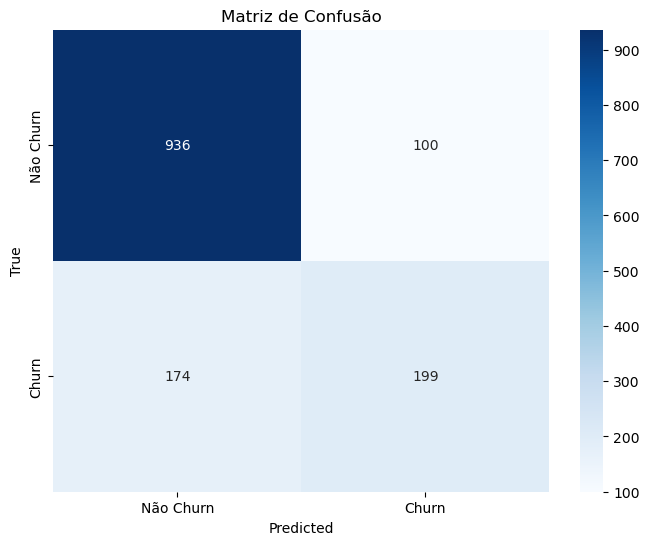

In [37]:
# Criar a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Churn', 'Churn'], yticklabels=['Não Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()


### Curva ROC

A curva ROC mostra a relação entre a taxa de verdadeiros positivos (TPR) e a taxa de falsos positivos (FPR). A área sob a curva (AUC) é uma métrica importante para avaliar a capacidade do modelo em distinguir entre classes.


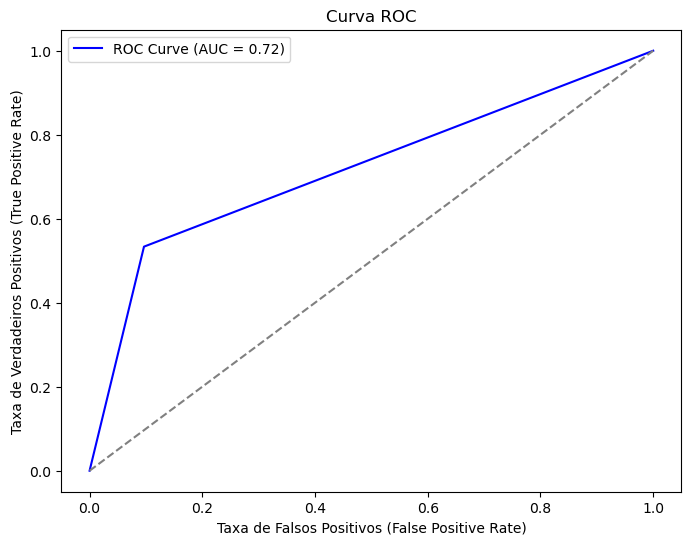

In [38]:
# Supondo que prediction_values contenha as probabilidades de 'Churn'
y_pred_proba = np.array(prediction_values)

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = roc_auc_score(y_true, y_pred_proba)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC')
plt.legend()
plt.show()


### Relatório de Classificação

O relatório de classificação exibe as principais métricas de avaliação (acurácia, precisão, recall, F1-score) de forma organizada para cada classe.

In [39]:
# Exibir o relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_true, y_pred))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.67      0.53      0.59       373

    accuracy                           0.81      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



# Excluir endpoint

In [41]:
import boto3
import sagemaker

# Criar uma sessão do SageMaker
sagemaker_session = sagemaker.Session()

# Nome do endpoint que você deseja excluir
endpoint_name = 'sagemaker-scikit-learn-2024-10-16-02-07-20-273'

# Excluir o endpoint
sagemaker_session.delete_endpoint(endpoint_name)

print(f"Endpoint '{endpoint_name}' excluído com sucesso.")

INFO:sagemaker:Deleting endpoint with name: sagemaker-scikit-learn-2024-10-16-02-07-20-273


Endpoint 'sagemaker-scikit-learn-2024-10-16-02-07-20-273' excluído com sucesso.


# Excluir modelo

In [45]:
# Excluir o modelo associado ao endpoint
sagemaker_session.delete_model('sagemaker-scikit-learn-2024-10-16-01-04-22-583')

print(f"Modelo associado ao endpoint '{endpoint_name}' excluído com sucesso.")

INFO:sagemaker:Deleting model with name: sagemaker-scikit-learn-2024-10-16-01-04-22-583


Modelo associado ao endpoint 'sagemaker-scikit-learn-2024-10-16-02-07-20-273' excluído com sucesso.
